# Using deep learning to classify Weibull patterns 

## Overview 
Although distribution fitting is easy to do with MLE, the workflow usually assumes there is a human in the loop to validate fits. To scale this up, we need an approach that can take arbitrary sample sizes, engineer features that are relevant to distribution fitting, and then do the fit or classify the category of distribution. Here, we use an autoencoder to get a standard set of features regardless of sample size, then pass the encoded samples to a classifier. 

## Notes
1. Min-max scaling helps deal with sample from Weibulls of different scales and speeds up autoencoder training. We don't particularly care about estimating the scale parameter, so this is fine. 
1. Autoencoder can encode to 30 dimensions. We only work with sample of size 31 and above, so this shouldn't represent more dimensions than data points in a sample. Arguably, distribution fitting boils data down to only 2 or 3 parameters, which is not enough to deal with all the complexity in the case where we can't be sure that data is "nearly Weibull". The autoencoder with 30 dimensions can represent the data more richly. 


## Next steps 
1. Define the classifier NN. Train on the training samples. Quantify performance on the test samples. 
2. How to deal with shape=1? Where do we set the boundaries? 
3. Try changing the autoencoder architecture. Do we need more layers? 
  1. Do we need more layers? 
  1. Add dropout?
  1. Inputs: instead of just the raw sample, add histogram representation(s), and/or ecdf quantiles 
4. Autoencoder training: 
  1. Instead of nn.MSELoss, use a loss function based on KL Divergence, Wasserstein distance, or Anderson-Darling test stat. 
 

In [1]:
import numpy as np
import pandas as pd 
from scipy.stats import weibull_min, norm
from enum import Enum, auto
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from umap import UMAP
import seaborn as sns 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data generation

In [2]:
class DistributionCategory(Enum):
    LESS_THAN_ONE = auto()
    GREATER_THAN_ONE = auto()
    OTHER = auto()

In [3]:
np.random.seed(42)
num_samples = 8000
max_obs_per_sample = 1000
data_samples = []
labels = []

In [4]:
for _ in range(num_samples):
    n = np.random.randint(31, max_obs_per_sample + 1)
    category = np.random.choice([DistributionCategory.LESS_THAN_ONE, DistributionCategory.GREATER_THAN_ONE, DistributionCategory.OTHER])
    
    if category == DistributionCategory.LESS_THAN_ONE:
        shape = np.random.uniform(0.1, 0.99)
        scale = np.random.uniform(100, 10000)
        sample = weibull_min.rvs(c=shape, scale=scale, size=n)
        
    elif category == DistributionCategory.GREATER_THAN_ONE:
        shape = np.random.uniform(1.01, 10.0)
        scale = np.random.uniform(100, 10000)
        sample = weibull_min.rvs(c=shape, scale=scale, size=n)
        
    else:
        # Uniform distribution
        if np.random.random() < 0.5:
            low = np.random.uniform(0, 0)
            high = np.random.uniform(100, 10000)
            sample = np.random.uniform(low, high, size=n)
        # Bimodal distribution
        else:
            mean1 = np.random.uniform(-50, -25)
            mean2 = np.random.uniform(25, 50)
            std1 = np.random.uniform(1, 10)
            std2 = np.random.uniform(1, 10)
            dist1 = norm(loc=mean1, scale=std1)
            dist2 = norm(loc=mean2, scale=std2)
            sample = np.concatenate([dist1.rvs(size=n//2), dist2.rvs(size=n//2)])
            np.random.shuffle(sample)
    
    data_samples.append(sample)
    labels.append(category)

In [5]:
# min-max scaling and padding the data: 
data_samples_min_max_scaled = [(sample - sample.min()) / (sample.max() - sample.min()) for sample in data_samples]
data_samples_preprocessed = [np.pad(sample, (0, max_obs_per_sample - len(sample))) for sample in data_samples_min_max_scaled]

In [6]:
labels = pd.Series(labels)

In [7]:
labels.head()

0       DistributionCategory.LESS_THAN_ONE
1       DistributionCategory.LESS_THAN_ONE
2               DistributionCategory.OTHER
3    DistributionCategory.GREATER_THAN_ONE
4       DistributionCategory.LESS_THAN_ONE
dtype: object

In [8]:
labels.value_counts()

DistributionCategory.OTHER               2679
DistributionCategory.GREATER_THAN_ONE    2672
DistributionCategory.LESS_THAN_ONE       2649
dtype: int64

782


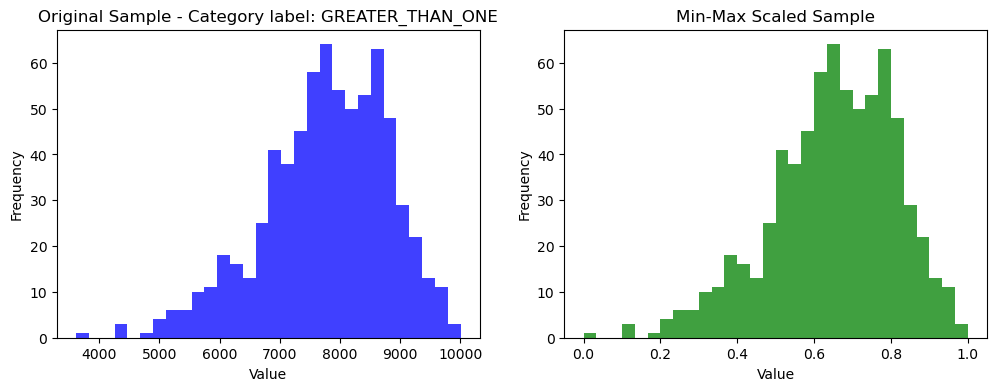

In [9]:
# Select a single sample from the data_samples list
sample_index = np.random.randint(len(labels) + 1, size=1).tolist()[0]
print(sample_index)

sample = data_samples[sample_index]
label = labels[sample_index]

# Apply min-max scaling to the selected sample
sample_min_max_scaled = data_samples_min_max_scaled[sample_index]

# Plot the histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(sample, bins=30, alpha=0.75, color='blue')
ax1.set_title(f'Original Sample - Category label: {label.name}')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')

ax2.hist(sample_min_max_scaled, bins=30, alpha=0.75, color='green')
ax2.set_title('Min-Max Scaled Sample')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

plt.show()


## Train/test split 

In [10]:
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(data_samples_preprocessed, labels, test_size=0.2, random_state=42)

# Example a randomly selected sample: 
sample_idx = np.random.randint(len(X_train_and_val))
assert type(X_train_and_val) == list 
assert type(X_train_and_val[sample_idx]) == np.ndarray
assert X_train_and_val[sample_idx].shape == (max_obs_per_sample,)  # this is due to padding

## Autoencoder architecture

In [11]:
input_size = max_obs_per_sample
embedding_size = 30

class Autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(input_size, embedding_size)

In [12]:
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1000, bias=True)
    (5): ReLU()
  )
)

## Autoencoder training 

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.2, random_state=42)

# Convert Enum labels to integers
y_train_int = [label.value for label in y_train]
y_val_int = [label.value for label in y_val]

# Convert data to PyTorch tensors
y_train_tensor = torch.tensor(y_train_int, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_int, dtype=torch.long)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

assert X_train_tensor.shape == (len(X_train), max_obs_per_sample)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
  # Remove the CWD from sys.path while we load stuff.


In [14]:
# Training parameters
epochs = 300
batch_size = 256
learning_rate = 0.001
patience = 10 

autoencoder = Autoencoder(input_size, embedding_size).to(device)

# Set loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Initialize variables for early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# Train the autoencoder
autoencoder.train()
for epoch in range(epochs):
    for batch_idx in range(0, len(X_train_tensor), batch_size):
        batch = X_train_tensor[batch_idx:batch_idx+batch_size, :].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        
    # Calculate validation loss
    autoencoder.eval()
    val_outputs = autoencoder(X_val_tensor.to(device))
    val_loss = criterion(val_outputs.to(device), X_val_tensor.to(device))

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Print progress
    if (epoch + 1) % 10 == 0 or epochs_without_improvement == 1:
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    # Stop training if no improvement for 'patience' epochs
    if epochs_without_improvement >= patience:
        print(f'Early stopping triggered at epoch {epoch + 1}.')
        break

Epoch [10/300], Training Loss: 0.0443, Validation Loss: 0.0398
Epoch [20/300], Training Loss: 0.0424, Validation Loss: 0.0382
Epoch [30/300], Training Loss: 0.0409, Validation Loss: 0.0370
Epoch [39/300], Training Loss: 0.0401, Validation Loss: 0.0363
Epoch [40/300], Training Loss: 0.0398, Validation Loss: 0.0363
Epoch [50/300], Training Loss: 0.0385, Validation Loss: 0.0351
Epoch [60/300], Training Loss: 0.0376, Validation Loss: 0.0344
Epoch [66/300], Training Loss: 0.0373, Validation Loss: 0.0342
Epoch [69/300], Training Loss: 0.0373, Validation Loss: 0.0342
Epoch [70/300], Training Loss: 0.0372, Validation Loss: 0.0343
Epoch [73/300], Training Loss: 0.0371, Validation Loss: 0.0342
Epoch [80/300], Training Loss: 0.0363, Validation Loss: 0.0335
Epoch [82/300], Training Loss: 0.0361, Validation Loss: 0.0333
Epoch [86/300], Training Loss: 0.0361, Validation Loss: 0.0332
Epoch [90/300], Training Loss: 0.0359, Validation Loss: 0.0332
Epoch [93/300], Training Loss: 0.0358, Validation Loss:

## Autoencoder inference on training data

In [15]:
if autoencoder.training: 
    autoencoder.eval()
    
with torch.no_grad(): 
    out = autoencoder.encoder(X_train_tensor.to(device))

In [16]:
out.shape

torch.Size([5120, 30])

### Visualizing the AE ouputs in 2D
This can be helpful in understanding whether a classifier will be able to distinguish the classes

In [17]:
mapper = UMAP(n_components=2, metric='cosine', random_state=2023).fit(out.cpu())

df_umap_2d = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_umap_2d['label'] = [enum.name for enum in y_train]
df_umap_2d

,X,Y,label
0,-1.566787,0.015114,LESS_THAN_ONE
1,-1.954772,7.267097,GREATER_THAN_ONE
2,11.584299,8.415017,OTHER
3,-2.611721,5.915339,GREATER_THAN_ONE
4,2.946873,10.428603,OTHER
...,...,...,...
5115,-2.812177,1.922298,LESS_THAN_ONE
5116,3.997527,2.583323,LESS_THAN_ONE
5117,16.083071,0.453157,OTHER
5118,8.939836,9.633349,OTHER


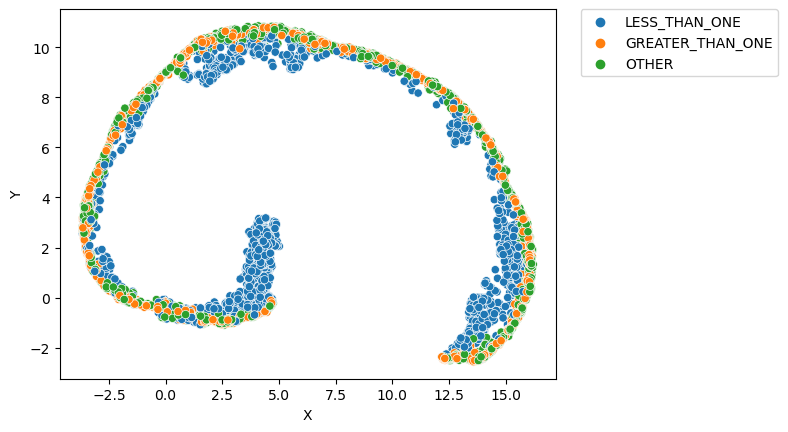

In [18]:
sns.scatterplot(data=df_umap_2d, x='X', y='Y', hue='label')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

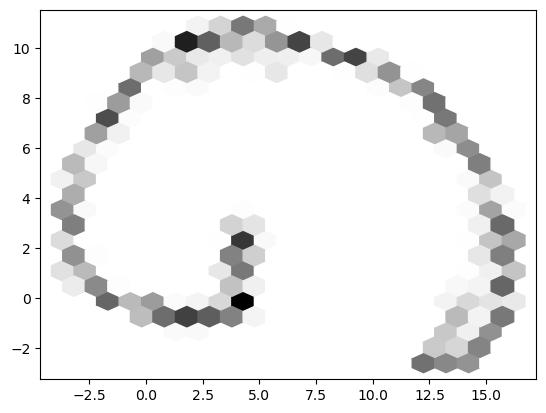

In [19]:
fig, ax = plt.subplots()
ax.hexbin(
    df_umap_2d['X'],
    df_umap_2d['Y'],
    cmap="Greys", 
    gridsize=20
)
fig.show()

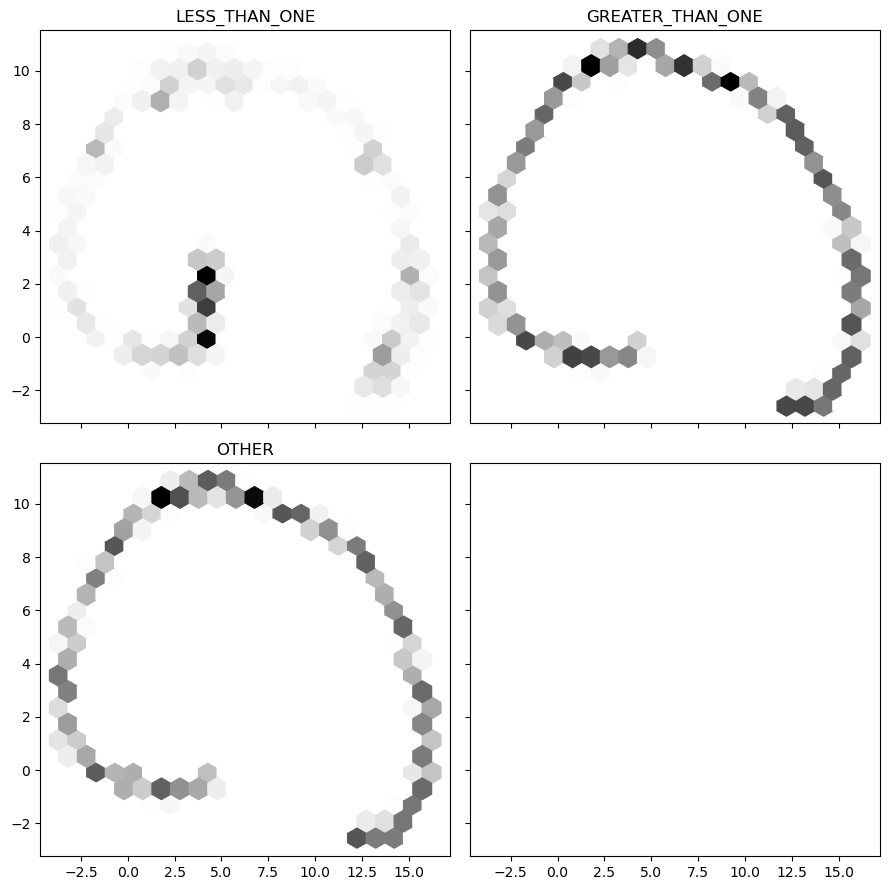

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(9,9), sharex=True, sharey=True)
axes = axes.flatten()
labels = df_umap_2d['label'].unique()
cmap = "Greys"

for i, label in enumerate(labels): 
    df_umap_sub = df_umap_2d.query('label==@label')
    axes[i].hexbin(
        df_umap_sub['X'], 
        df_umap_sub['Y'], 
        cmap=cmap, 
        gridsize=20
    )
    axes[i].set_title(label)
plt.tight_layout()
plt.show()
